In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df_clean = pd.read_csv("cleaned_traffic_crashes.csv")
df_clean.head()

,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,...,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,location
0,30,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,NOT DIVIDED,STRAIGHT AND LEVEL,SNOW OR SLUSH,NO DEFECTS,...,0.0,0.0,0.0,0.0,1.0,0.0,22,4,1,POINT (-87.551093105845 41.713829100033)
1,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,0.0,2.0,0.0,22,4,1,POINT (-87.755202215729 41.796710893317)
2,30,OTHER,OTHER,OTHER,UNKNOWN,PARKED MOTOR VEHICLE,OTHER,STRAIGHT AND LEVEL,OTHER,UNKNOWN,...,0.0,0.0,0.0,0.0,2.0,0.0,22,4,1,POINT (-87.603822899265 41.813004951227)
3,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,0.0,3.0,0.0,22,4,1,POINT (-87.705668192505 41.868335288795)
4,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,...,0.0,0.0,0.0,0.0,2.0,0.0,22,4,1,POINT (-87.696128029764 41.866617682133)


In [3]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024029 entries, 0 to 1024028
Data columns (total 33 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   posted_speed_limit             1024029 non-null  int64  
 1   traffic_control_device         1024029 non-null  object 
 2   device_condition               1024029 non-null  object 
 3   weather_condition              1024029 non-null  object 
 4   lighting_condition             1024029 non-null  object 
 5   first_crash_type               1024029 non-null  object 
 6   trafficway_type                1024029 non-null  object 
 7   alignment                      1024029 non-null  object 
 8   roadway_surface_cond           1024029 non-null  object 
 9   road_defect                    1024029 non-null  object 
 10  report_type                    1024029 non-null  object 
 11  crash_type                     1024029 non-null  object 
 12  damage        

In [4]:
df_clean.isnull().sum()

posted_speed_limit               0
traffic_control_device           0
device_condition                 0
weather_condition                0
lighting_condition               0
first_crash_type                 0
trafficway_type                  0
alignment                        0
roadway_surface_cond             0
road_defect                      0
report_type                      0
crash_type                       0
damage                           0
date_police_notified             0
prim_contributory_cause          0
sec_contributory_cause           0
street_no                        0
street_direction                 0
street_name                      0
beat_of_occurrence               0
num_units                        0
most_severe_injury               0
injuries_total                   0
injuries_fatal                   0
injuries_incapacitating          0
injuries_non_incapacitating      0
injuries_reported_not_evident    0
injuries_no_indication           0
injuries_unknown    

In [5]:
df_clean.duplicated().value_counts()

False    1023967
True          62
dtype: int64

In [6]:
df_clean = df_clean.drop_duplicates()
df_clean.duplicated().value_counts()

False    1023967
dtype: int64

In [7]:
columns_to_drop = ['date_police_notified', 'street_name', 'location', 'sec_contributory_cause', 'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication',
       'injuries_unknown']
df_clean = df_clean.drop(columns=columns_to_drop)

In [8]:
df_clean['prim_contributory_cause']

0                    UNABLE TO DETERMINE
1                    UNABLE TO DETERMINE
2                    UNABLE TO DETERMINE
3            IMPROPER OVERTAKING/PASSING
4                    IMPROPER LANE USAGE
                       ...              
1024024              UNABLE TO DETERMINE
1024025    FAILING TO YIELD RIGHT-OF-WAY
1024026              UNABLE TO DETERMINE
1024027              UNABLE TO DETERMINE
1024028              IMPROPER LANE USAGE
Name: prim_contributory_cause, Length: 1023967, dtype: object

In [9]:
cause_mapping = {
    # Treat undetermined as missing so we can drop those rows
    'UNABLE TO DETERMINE': np.nan,

    # Driver Error
    'FAILED TO REDUCE SPEED TO AVOID CRASH': 'Driver Error',
    'IMPROPER OVERTAKING/PASSING': 'Driver Error',
    'FOLLOWING TOO CLOSELY': 'Driver Error',
    'FAILING TO YIELD RIGHT-OF-WAY': 'Driver Error',
    'DISREGARDING TRAFFIC SIGNALS': 'Driver Error',
    'DISREGARDING STOP SIGN': 'Driver Error',
    'IMPROPER LANE USAGE': 'Driver Error',
    'IMPROPER TURNING/NO SIGNAL': 'Driver Error',
    'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 'Driver Error',
    'DISREGARDING OTHER TRAFFIC SIGNS': 'Driver Error',
    'IMPROPER BACKING': 'Driver Error',
    'DISTRACTION - FROM INSIDE VEHICLE': 'Driver Error',

    # Non-Driver Technical (merge External + Vehicle Defect)
    'WEATHER': 'Non-Driver Technical',
    'ROAD ENGINEERING/SURFACE/MARKING DEFECTS': 'Non-Driver Technical',
    'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)': 'Non-Driver Technical',
    'DISTRACTION - FROM OUTSIDE VEHICLE': 'Non-Driver Technical',
    'EQUIPMENT - VEHICLE CONDITION': 'Non-Driver Technical',

    # Other
    'OTHER': 'Other'
}
df_clean['Crash_Cause'] = df_clean['prim_contributory_cause'].map(cause_mapping)

# Convert unmapped known causes to 'Other' FIRST
df_clean['Crash_Cause'] = df_clean['Crash_Cause'].fillna('Other')

# Now drop only the undetermined ones (which we set to NaN explicitly)
df_clean = df_clean[df_clean['prim_contributory_cause'] != 'UNABLE TO DETERMINE']

# Drop original
df_clean = df_clean.drop(columns=['prim_contributory_cause'])

df_clean['Crash_Cause'].value_counts()

Driver Error            447775
Other                   139539
Non-Driver Technical     33686
Name: Crash_Cause, dtype: int64

In [10]:
df_clean.columns

Index(['posted_speed_limit', 'traffic_control_device', 'device_condition',
       'weather_condition', 'lighting_condition', 'first_crash_type',
       'trafficway_type', 'alignment', 'roadway_surface_cond', 'road_defect',
       'report_type', 'crash_type', 'damage', 'street_no', 'street_direction',
       'beat_of_occurrence', 'num_units', 'crash_hour', 'crash_day_of_week',
       'crash_month', 'Crash_Cause'],
      dtype='object')

In [11]:
#Define X and Y
X = df_clean.drop(['Crash_Cause'], axis=1)
y = df_clean['Crash_Cause']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((465750, 20), (155250, 20))

In [13]:
X_train.head()

,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,report_type,crash_type,damage,street_no,street_direction,beat_of_occurrence,num_units,crash_hour,crash_day_of_week,crash_month
824940,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,"$501 - $1,500",230,W,1821.0,2,11,1,7
977609,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,"OVER $1,500",6925,S,833.0,2,11,1,11
794252,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",1456,S,1011.0,2,11,3,10
849623,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,ONE-WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"$501 - $1,500",4143,N,1723.0,2,17,7,4
165977,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,"OVER $1,500",5602,W,812.0,2,18,7,7


In [14]:
X_test.head()

,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,report_type,crash_type,damage,street_no,street_direction,beat_of_occurrence,num_units,crash_hour,crash_day_of_week,crash_month
148672,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,DRY,WORN SURFACE,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",200,W,914.0,2,12,5,9
111221,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",5697,N,2013.0,2,7,6,1
701059,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,ANGLE,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,$500 OR LESS,4001,N,1724.0,2,12,3,7
424228,30,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,WET,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",659,N,1524.0,2,15,4,3
934610,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",6526,W,1632.0,2,0,1,7


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

from sklearn.inspection import permutation_importance

In [16]:
# Group rare categories → much fewer one-hot columns
rare_threshold = 200   # adjust if needed (higher = fewer columns)

for col in ['street_name', 'first_crash_type', 'trafficway_type']:  # add your high-cardinality columns
    if col in X_train.columns:
        counts = X_train[col].value_counts()
        common = counts[counts >= rare_threshold].index
        X_train[col] = X_train[col].where(X_train[col].isin(common), 'Rare/Other')
        X_test[col]  = X_test[col].where(X_test[col].isin(common), 'Rare/Other')
        print(f"Reduced {col}: {len(common)} common categories kept")

Reduced first_crash_type: 17 common categories kept
Reduced trafficway_type: 18 common categories kept


In [17]:
categorical_features = X_train.select_dtypes(include=['object']).columns
numeric_features = X_train.select_dtypes(exclude=['object']).columns

In [18]:
# Drop very high categorical columns from OHE to save memory
high_card = ['LOCATION', 'STREET_NAME', 'DATE_POLICE_NOTIFIED']
cat_reduced = [c for c in categorical_features if c not in high_card]

preprocessor_light = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=True), cat_reduced),
        ('num', StandardScaler(), numeric_features)
    ]
)

In [19]:

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # handles missing values
    ("ohe", OneHotEncoder(handle_unknown="ignore")) # encoding categories
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

In [20]:
# Model Pipeline
tree_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(max_depth=5, random_state=42))
])

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(n_estimators=50,class_weight='balanced_subsample', max_depth=15,max_features="sqrt",
                                     min_samples_leaf=5, random_state=42, n_jobs=-1,))
])

In [21]:
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        random_state=42 ))
])

In [22]:
def evaluate(name, pipe):
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    acc = accuracy_score(y_test, preds)
    macro_f1 = f1_score(y_test, preds, average="macro")

    print("\n" + "="*70)
    print(name)
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1 : {macro_f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, preds))

    cm = confusion_matrix(y_test, preds, labels=pipe.classes_)
    ConfusionMatrixDisplay(cm, display_labels=pipe.classes_).plot(xticks_rotation=30)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    return {"Model": name, "Accuracy": acc, "Macro_F1": macro_f1}


Logistic Regression
Accuracy: 0.6100
Macro F1 : 0.4868

Classification report:
                      precision    recall  f1-score   support

        Driver Error       0.85      0.65      0.74    111944
Non-Driver Technical       0.20      0.59      0.30      8421
               Other       0.38      0.49      0.42     34885

            accuracy                           0.61    155250
           macro avg       0.48      0.57      0.49    155250
        weighted avg       0.71      0.61      0.64    155250



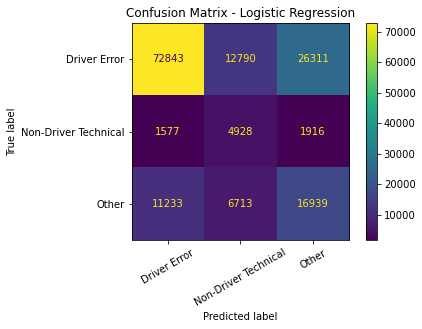

In [23]:
# Evaluate logistic regression model and store results
results = []
result_logreg = evaluate("Logistic Regression", logreg_pipe)
results.append(result_logreg)


Decision Tree
Accuracy: 0.7463
Macro F1 : 0.4472

Classification report:
                      precision    recall  f1-score   support

        Driver Error       0.77      0.97      0.85    111944
Non-Driver Technical       0.47      0.13      0.21      8421
               Other       0.57      0.18      0.28     34885

            accuracy                           0.75    155250
           macro avg       0.60      0.43      0.45    155250
        weighted avg       0.70      0.75      0.69    155250



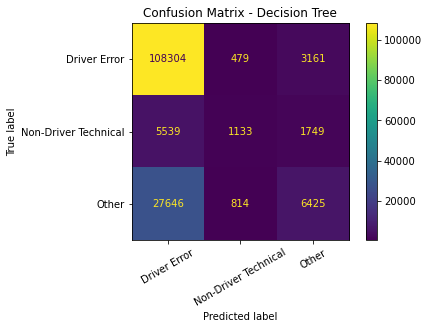

In [24]:
# Evaluate decision tree model and store results
result_tree = evaluate("Decision Tree", tree_pipe)
results.append(result_tree)


Random Forest
Accuracy: 0.6335
Macro F1 : 0.5015

Classification report:
                      precision    recall  f1-score   support

        Driver Error       0.85      0.68      0.76    111944
Non-Driver Technical       0.21      0.58      0.30      8421
               Other       0.41      0.49      0.44     34885

            accuracy                           0.63    155250
           macro avg       0.49      0.58      0.50    155250
        weighted avg       0.72      0.63      0.66    155250



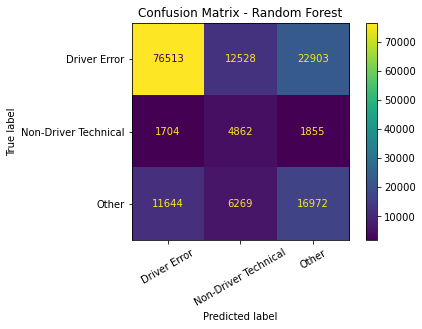

In [25]:
# Evaluate random forest model and store results
result_rf = evaluate("Random Forest", rf_pipe)
results.append(result_rf)